**Reference**: Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder

This file trains an autoencoder with the instances of the normal digit in the training data. 

Then, it measures the reconstruction loss for the digits in the test data.

The reconstruction loss for the instances of the abnormal digit in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).  

Then, if the reconstruction loss of a digit in the test data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal digit(s) and F for abnormal digit(s)), the confusion matrix and the accuracy is calculated. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import cifar10
from keras.models import Model
# import cv2

**Loading the CIFAR10 data and forming arrays of the normal training data and the test data (normal and abnormal)**

In [2]:
nl1 = 0   # airplane
nl2 = 0   # airplane
abn = 8   # ship

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

normal_data = x_train[(y_train == nl1).flatten() | (y_train == nl2).flatten()]    # Normal training data (cats)
normal_labels = y_train[(y_train == nl1).flatten() | (y_train == nl2).flatten()]

test_data = x_test[(y_test == abn).flatten() | (y_test == nl1).flatten() | (y_test == nl2).flatten()]   # Test data (ships)
test_labels = y_test[(y_test == abn).flatten() | (y_test == nl1).flatten() | (y_test == nl2).flatten()]

test_labels_T_F = np.where((test_labels == nl1).flatten() | (test_labels == nl2).flatten(), True, False) 
# Array of T and F, T where test classes are normal and F where test classes are abnormal

170508288/170498071 [==============================] - 3s 0us/step


In [3]:
normal_data.shape, test_data.shape, test_labels.shape

((5000, 32, 32, 3), (2000, 32, 32, 3), (2000, 1))

In [4]:
normal_test_data = test_data[(test_labels == nl1).flatten() | (test_labels == nl2).flatten()]   # The normal classes in the test data
abnormal_test_data = test_data[(test_labels == abn).flatten()]                          # The abnormal classes in the test data
normal_test_labels = test_labels[(test_labels == nl1).flatten() | (test_labels == nl2).flatten()]   # Their labels
abnormal_test_labels = test_labels[(test_labels == abn).flatten()]                          # Their labels

In [5]:
normal_test_data.shape, abnormal_test_data.shape

((1000, 32, 32, 3), (1000, 32, 32, 3))

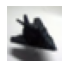

In [6]:
# First normal digit
plt.figure(figsize=(1,1))
plt.imshow(normal_data[0], cmap="binary")
plt.axis('off')
plt.show()

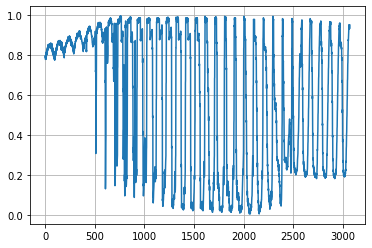

In [7]:
# 1 dim plot of (flattened array of) first normal digit
plt.grid()
# size of image * 3 colors for RGB
plt.plot(np.arange(32*32*3), normal_data[0].ravel())
plt.show()

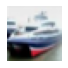

In [8]:
# first test digit
plt.figure(figsize=(1,1))
plt.imshow(test_data[0], cmap="binary")
plt.axis('off')
plt.show()

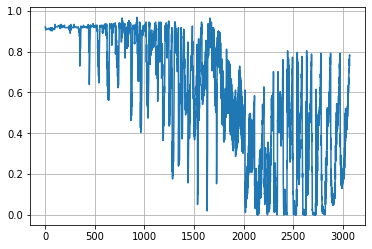

In [9]:
# 1 dim plot of first test digit
plt.grid()
plt.plot(np.arange(32*32*3), test_data[0].ravel())
plt.show()

In [31]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(1024, activation="selu"),
      layers.Dense(512, activation="selu"),
      layers.Dense(256, activation="selu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(512, activation="selu"),
      layers.Dense(1024, activation="selu"),
      layers.Dense(32*32*3, activation="sigmoid"), # include RGB
      layers.Reshape((32, 32, 3))]) # 3 dimensional because RGB

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [32]:
# autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [33]:
history = autoencoder.fit(normal_data, normal_data, 
          epochs=200, 
          batch_size=256,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/200
20/20 [==============================] - 1s 27ms/step - loss: 0.9424 - val_loss: 0.6951
Epoch 2/200
20/20 [==============================] - 0s 15ms/step - loss: 0.7245 - val_loss: 0.7473
Epoch 3/200
20/20 [==============================] - 0s 15ms/step - loss: 0.7310 - val_loss: 0.7281
Epoch 4/200
20/20 [==============================] - 0s 13ms/step - loss: 0.7276 - val_loss: 0.7184
Epoch 5/200
20/20 [==============================] - 0s 14ms/step - loss: 0.7282 - val_loss: 0.6803
Epoch 6/200
20/20 [==============================] - 0s 14ms/step - loss: 0.7080 - val_loss: 0.7218
Epoch 7/200
20/20 [==============================] - 0s 14ms/step - loss: 0.7391 - val_loss: 0.6644
Epoch 8/200
20/20 [==============================] - 0s 14ms/step - loss: 0.6882 - val_loss: 0.6623
Epoch 9/200
20/20 [==============================] - 0s 14ms/step - loss: 0.7140 - val_loss: 0.6808
Epoch 10/200
20/20 [==============================] - 0s 14ms/step - loss: 0.6817 - val_loss: 0.6888

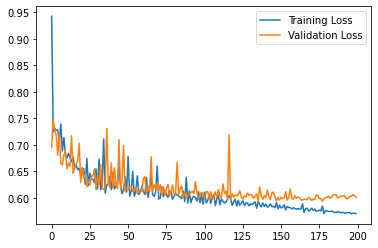

In [34]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

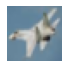

In [35]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(1,1))
plt.imshow(normal_test_data[1], cmap="binary")
plt.axis('off')
plt.show()

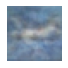

In [36]:
plt.figure(figsize=(1,1))
plt.imshow(decoded_data[1], cmap="binary")
plt.axis('off')
plt.show()

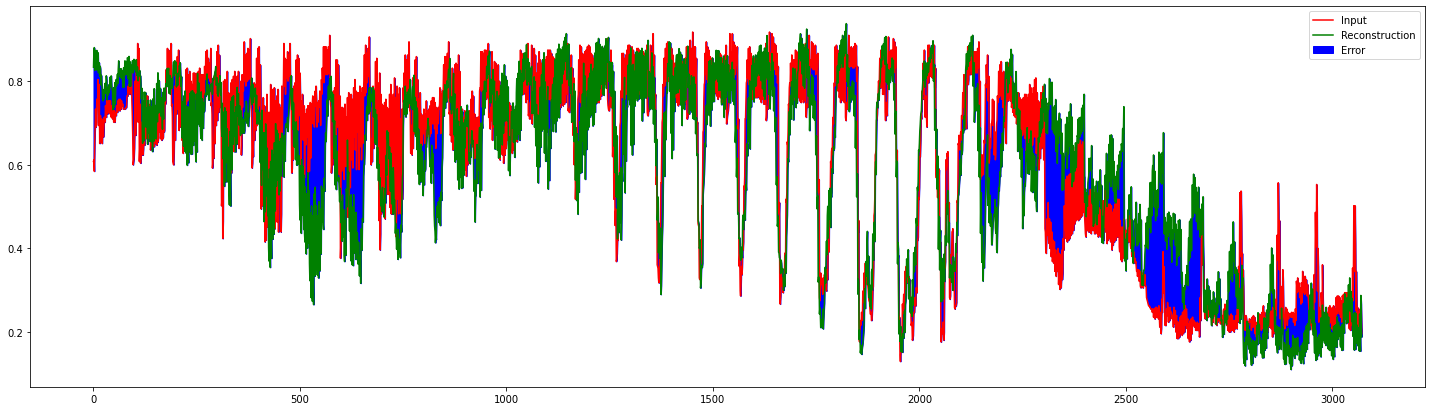

In [37]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(decoded_data[0].ravel(), 'g')
plt.fill_between(np.arange(32*32*3), decoded_data[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

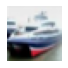

In [38]:
encoded_abn_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_abn_data = autoencoder.decoder(encoded_abn_data).numpy()

plt.figure(figsize=(1,1))
plt.imshow(abnormal_test_data[0], cmap="binary")
plt.axis('off')
plt.show()

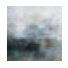

In [39]:
plt.figure(figsize=(1,1))
plt.imshow(decoded_abn_data[0], cmap="binary")
plt.axis('off')
plt.show()

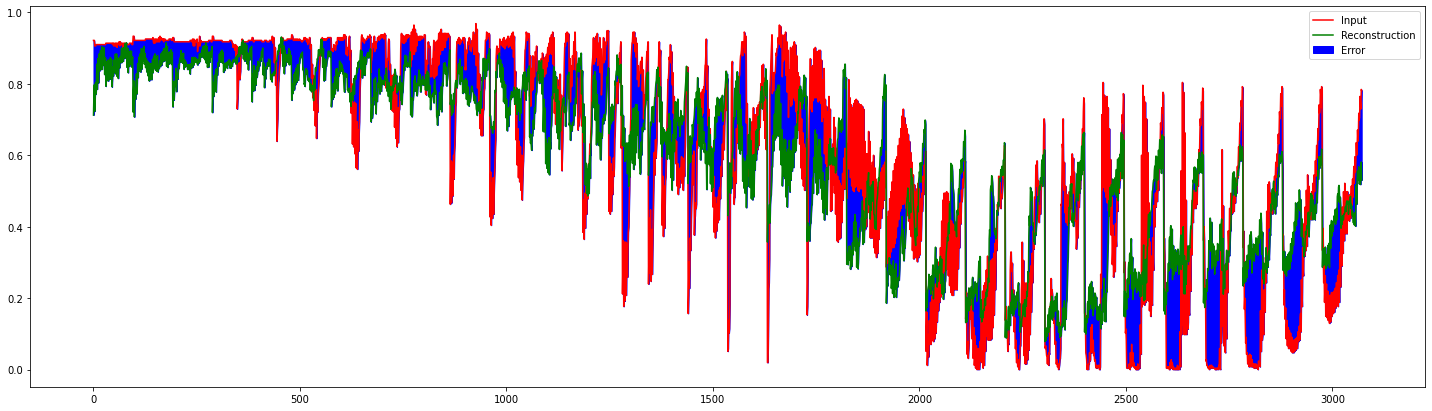

In [40]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(decoded_abn_data[0].ravel(), 'g')
plt.fill_between(np.arange(32*32*3), decoded_abn_data[0].ravel(), abnormal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

**Distribution of the reconstruction losses of the normal training data**

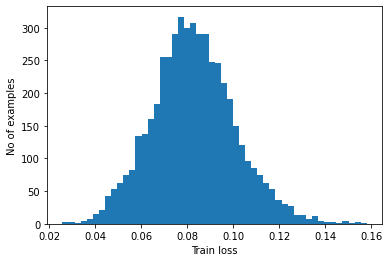

In [41]:
reconstructions = autoencoder.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 32*32*3), normal_data.reshape(-1, 32*32*3))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [42]:
print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))

Mean:  0.08287411
Std:  0.018133018


In [43]:
threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold1: ", threshold1)

Threshold1:  0.1282066572457552


**Distribution of the reconstruction losses of the abnormal test data**

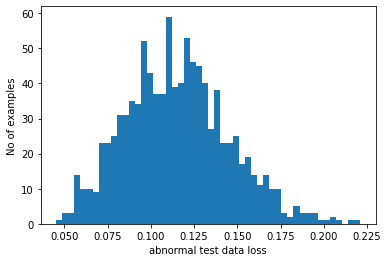

In [44]:
reconstructions = autoencoder.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 32*32*3), abnormal_test_data.reshape(-1, 32*32*3))

plt.hist(abn_test_loss[None, :], bins=50)
plt.xlabel("abnormal test data loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
# threshold2 = np.mean(abn_test_loss) - np.std(abn_test_loss)
# print("Threshold2: ", threshold2)

In [45]:
np.mean(abn_test_loss) , np.std(abn_test_loss)

(0.11533489, 0.029831436)

**Threshold will be threshold1 = mean + std of the distribution of the reconstruction losses of the normal training data**

In [46]:
threshold = threshold1

**Calculation of the confusion matrix**

In [47]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 32*32*3), data.reshape(-1, 32*32*3))
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [48]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             531   1469
 label: F   [[324   676]    1000
        T    [207   793]]   1000
Accuracy = 0.5585
Precision = 0.5398230088495575
Recall = 0.793


In [29]:
print(confusion_matrix(test_labels_T_F, preds))

[[ 28 972]
 [ 21 979]]


**Distribution of the reconstruction losses of the test data (normal and abnormal)**

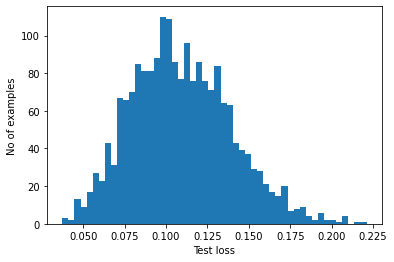

In [49]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,32*32*3), test_data.reshape(-1,32*32*3))

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()